In [2]:
# uncomment the next line if you want to delete an existing models directory
!rm -rf ./models/

# clone the Tensorflow Model Garden
!git clone --depth 1 https://github.com/tensorflow/models/

Cloning into 'models'...
remote: Enumerating objects: 2864, done.
remote: Counting objects: 100% (2864/2864), done.
remote: Compressing objects: 100% (2399/2399), done.
remote: Total 2864 (delta 726), reused 1279 (delta 429), pack-reused 0
Receiving objects: 100% (2864/2864), 32.88 MiB | 26.27 MiB/s, done.
Resolving deltas: 100% (726/726), done.


In [3]:
# install the Object Detection API
!cd models/research/ && protoc object_detection/protos/*.proto --python_out=. && cp object_detection/packages/tf2/setup.py . && sed -i 's/>=2.5.1/==2.5.0/' setup.py && python -m pip install .

Processing /content/models/research
  DEPRECATION: A future pip version will change local packages to be built in-place without first copying to a temporary directory. We recommend you use --use-feature=in-tree-build to test your packages with this new behavior before it becomes the default.
   pip 21.3 will remove support for this functionality. You can find discussion regarding this at https://github.com/pypa/pip/issues/7555.
     |████████████████████████████████| 9.8 MB 8.8 MB/s 
     |████████████████████████████████| 352 kB 47.4 MB/s 
     |████████████████████████████████| 1.6 MB 36.6 MB/s 
     |████████████████████████████████| 211 kB 48.7 MB/s 
     |████████████████████████████████| 43 kB 1.9 MB/s 
     |████████████████████████████████| 1.2 MB 31.9 MB/s 
     |████████████████████████████████| 99 kB 9.2 MB/s 
     |████████████████████████████████| 636 kB 44.9 MB/s 
     |████████████████████████████████| 90 kB 7.4 MB/s 
     |████████████████████████████████| 37.1 MB 47 kB

In [4]:
import matplotlib
import matplotlib.pyplot as plt

import os
import random
import zipfile
import io
import scipy.misc
import numpy as np

import glob
import imageio
from six import BytesIO
from PIL import Image, ImageDraw, ImageFont
from IPython.display import display, Javascript
from IPython.display import Image as IPyImage

try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

import tensorflow as tf
tf.get_logger().setLevel('ERROR')

In [5]:
from object_detection.utils import label_map_util
from object_detection.utils import config_util
from object_detection.utils import visualization_utils as viz_utils
from object_detection.builders import model_builder
from object_detection.utils import colab_utils

In [6]:
def load_image_into_numpy_array(path):
    
    img_data = tf.io.gfile.GFile(path, 'rb').read()
    image = Image.open(BytesIO(img_data))
    (im_width, im_height) = image.size
    
    return np.array(image.getdata()).reshape(
        (im_height, im_width, 3)).astype(np.uint8)


def plot_detections(image_np,
                    boxes,
                    classes,
                    scores,
                    category_index,
                    figsize=(12, 16),
                    image_name=None):
    
    image_np_with_annotations = image_np.copy()
    
    viz_utils.visualize_boxes_and_labels_on_image_array(
        image_np_with_annotations,
        boxes,
        classes,
        scores,
        category_index,
        use_normalized_coordinates=True,
        min_score_thresh=0.8)
    
    if image_name:
        plt.imsave(image_name, image_np_with_annotations)
    
    else:
        plt.imshow(image_np_with_annotations)


In [7]:
!wget --no-check-certificate \
    https://storage.googleapis.com/laurencemoroney-blog.appspot.com/training-zombie.zip \
    -O ./training-zombie.zip

local_zip = './training-zombie.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('./training')
zip_ref.close()

--2021-09-02 12:49:09--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/training-zombie.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.124.128, 172.217.212.128, 142.250.152.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.124.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1915446 (1.8M) [application/zip]
Saving to: ‘./training-zombie.zip’

./training-zombie.z 100%[===================>]   1.83M  --.-KB/s    in 0.02s   

2021-09-02 12:49:09 (111 MB/s) - ‘./training-zombie.zip’ saved [1915446/1915446]



./training/training-zombie1.jpg
./training/training-zombie2.jpg
./training/training-zombie3.jpg
./training/training-zombie4.jpg
./training/training-zombie5.jpg


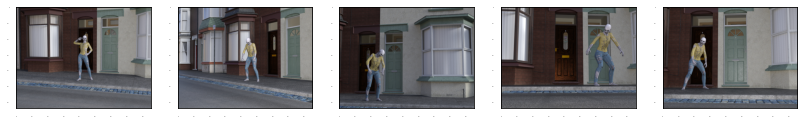

In [8]:
%matplotlib inline
train_image_dir = './training'


train_images_np = []

for i in range(1, 6):

    image_path = os.path.join("./training/training-zombie" + str(i) + ".jpg")
    print(image_path)

    train_images_np.append(load_image_into_numpy_array(image_path))

plt.rcParams['axes.grid'] = False
plt.rcParams['xtick.labelsize'] = False
plt.rcParams['ytick.labelsize'] = False
plt.rcParams['xtick.top'] = False
plt.rcParams['xtick.bottom'] = False
plt.rcParams['ytick.left'] = False
plt.rcParams['ytick.right'] = False
plt.rcParams['figure.figsize'] = [14, 7]

for idx, train_image_np in enumerate(train_images_np):
    plt.subplot(1, 5, idx+1)
    plt.imshow(train_image_np)

plt.show()

In [9]:
gt_boxes = []

In [10]:
# annotate the training images
colab_utils.annotate(train_images_np, box_storage_pointer=gt_boxes)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

'--boxes array populated--'

<IPython.core.display.Javascript object>

In [11]:
for gt_box in gt_boxes:
  print(gt_box)

[[0.282      0.42086753 0.73533333 0.57327081]]
[[0.30366666 0.46424385 0.74866666 0.6084408 ]]
[[0.417      0.19109027 0.942      0.34583822]]
[[0.167      0.61664713 0.78533333 0.91793669]]
[[0.302      0.12895662 0.83033333 0.33997655]]


In [12]:
zombie_class_id = 1
category_index = {zombie_class_id :
                  {'id' : zombie_class_id,
                   'name' : 'zombie'}
                  }
num_classes = 1

In [13]:
print(category_index[zombie_class_id])

{'id': 1, 'name': 'zombie'}


In [14]:
label_id_offset = 1
train_image_tensors = []

gt_classes_one_hot_tensors = []
gt_box_tensors = []

for (train_image_np, gt_box_np) in zip(train_images_np, gt_boxes):
    
    # convert training image to tensor, add batch dimension, and add to list
    train_image_tensors.append(tf.expand_dims(tf.convert_to_tensor(
        train_image_np, dtype=tf.float32), axis=0))
    
    # convert numpy array to tensor, then add to list
    gt_box_tensors.append(tf.convert_to_tensor(gt_box_np, dtype=tf.float32))
    
    # apply offset to to have zero-indexed ground truth classes
    zero_indexed_groundtruth_classes = tf.convert_to_tensor(
        np.ones(shape=[gt_box_np.shape[0]], dtype=np.int32) - label_id_offset)
    
    # do one-hot encoding to ground truth classes
    gt_classes_one_hot_tensors.append(tf.one_hot(
        zero_indexed_groundtruth_classes, num_classes))

print('Done')

Done


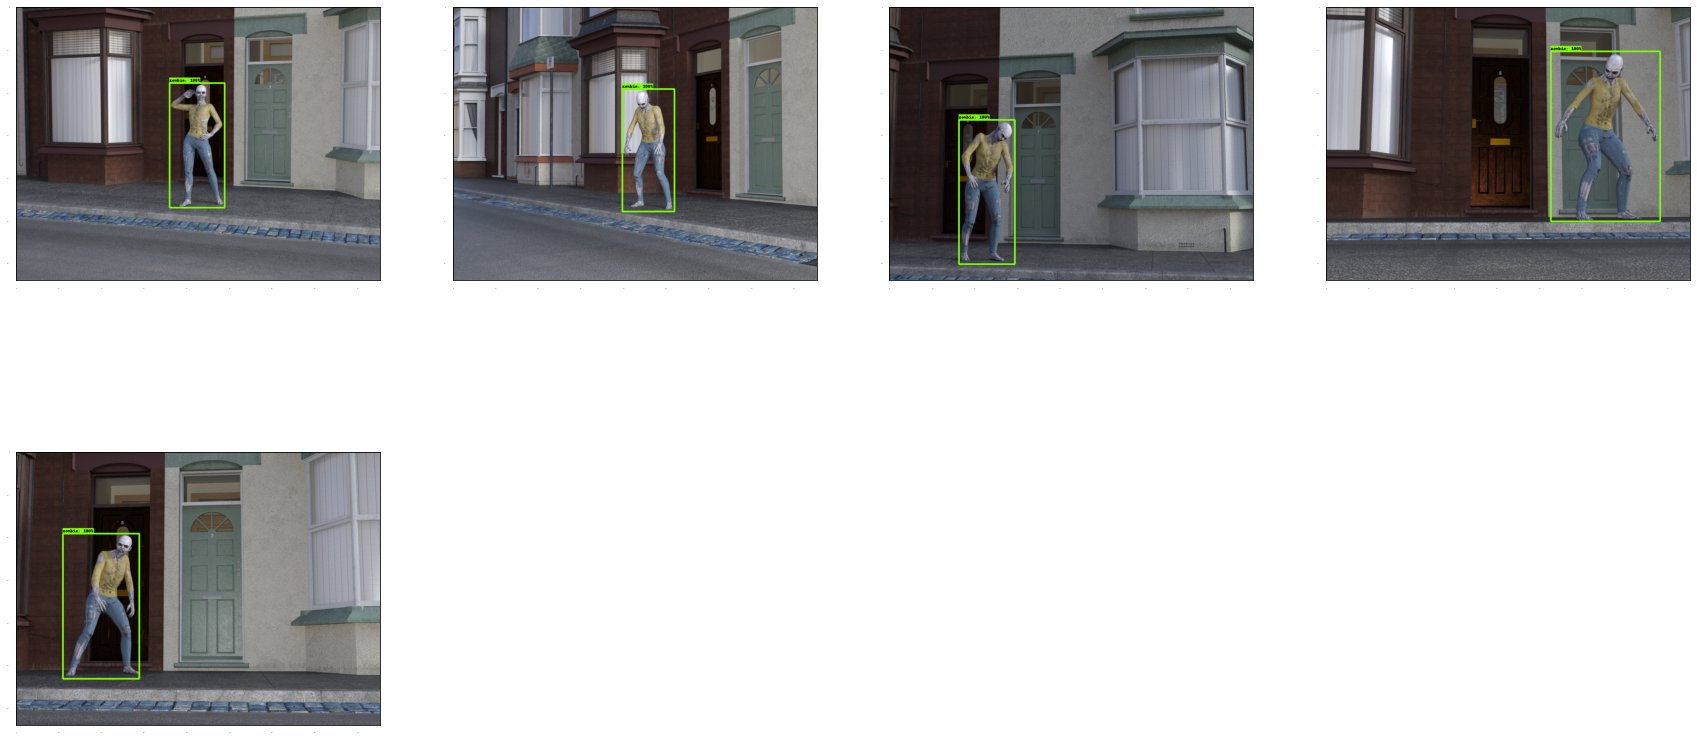

In [15]:
dummy_scores = np.array([1.0], dtype=np.float32)

plt.figure(figsize=(30, 15))

for idx in range(5):
    plt.subplot(2, 4, idx+1)
    plot_detections(
      train_images_np[idx],
      gt_boxes[idx],
      np.ones(shape=[gt_boxes[idx].shape[0]], dtype=np.int32),
      dummy_scores, category_index)

plt.show()

In [16]:
!wget http://download.tensorflow.org/models/object_detection/tf2/20200711/ssd_resnet50_v1_fpn_640x640_coco17_tpu-8.tar.gz
!tar -xf ssd_resnet50_v1_fpn_640x640_coco17_tpu-8.tar.gz
!mv ssd_resnet50_v1_fpn_640x640_coco17_tpu-8/checkpoint models/research/object_detection/test_data/

--2021-09-02 12:50:56--  http://download.tensorflow.org/models/object_detection/tf2/20200711/ssd_resnet50_v1_fpn_640x640_coco17_tpu-8.tar.gz
Resolving download.tensorflow.org (download.tensorflow.org)... 209.85.200.128, 2607:f8b0:4001:c1b::80
Connecting to download.tensorflow.org (download.tensorflow.org)|209.85.200.128|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 244817203 (233M) [application/x-tar]
Saving to: ‘ssd_resnet50_v1_fpn_640x640_coco17_tpu-8.tar.gz’

ssd_resnet50_v1_fpn 100%[===================>] 233.48M   190MB/s    in 1.2s    

2021-09-02 12:50:57 (190 MB/s) - ‘ssd_resnet50_v1_fpn_640x640_coco17_tpu-8.tar.gz’ saved [244817203/244817203]



## Configure the model


In [17]:
tf.keras.backend.clear_session()

pipeline_config =  "/content/models/research/object_detection/configs/tf2/ssd_resnet50_v1_fpn_640x640_coco17_tpu-8.config"

configs = config_util.get_configs_from_pipeline_file(pipeline_config)
configs

{'eval_config': metrics_set: "coco_detection_metrics"
 use_moving_averages: false,
 'eval_input_config': label_map_path: "PATH_TO_BE_CONFIGURED/label_map.txt"
 shuffle: false
 num_epochs: 1
 tf_record_input_reader {
   input_path: "PATH_TO_BE_CONFIGURED/val2017-?????-of-00032.tfrecord"
 },
 'eval_input_configs': [label_map_path: "PATH_TO_BE_CONFIGURED/label_map.txt"
 shuffle: false
 num_epochs: 1
 tf_record_input_reader {
   input_path: "PATH_TO_BE_CONFIGURED/val2017-?????-of-00032.tfrecord"
 }
 ],
 'model': ssd {
   num_classes: 90
   image_resizer {
     fixed_shape_resizer {
       height: 640
       width: 640
     }
   }
   feature_extractor {
     type: "ssd_resnet50_v1_fpn_keras"
     depth_multiplier: 1.0
     min_depth: 16
     conv_hyperparams {
       regularizer {
         l2_regularizer {
           weight: 0.00039999998989515007
         }
       }
       initializer {
         truncated_normal_initializer {
           mean: 0.0
           stddev: 0.029999999329447746
   

In [18]:
model_config = configs['model']

model_config

ssd {
  num_classes: 90
  image_resizer {
    fixed_shape_resizer {
      height: 640
      width: 640
    }
  }
  feature_extractor {
    type: "ssd_resnet50_v1_fpn_keras"
    depth_multiplier: 1.0
    min_depth: 16
    conv_hyperparams {
      regularizer {
        l2_regularizer {
          weight: 0.00039999998989515007
        }
      }
      initializer {
        truncated_normal_initializer {
          mean: 0.0
          stddev: 0.029999999329447746
        }
      }
      activation: RELU_6
      batch_norm {
        decay: 0.996999979019165
        scale: true
        epsilon: 0.0010000000474974513
      }
    }
    override_base_feature_extractor_hyperparams: true
    fpn {
      min_level: 3
      max_level: 7
    }
  }
  box_coder {
    faster_rcnn_box_coder {
      y_scale: 10.0
      x_scale: 10.0
      height_scale: 5.0
      width_scale: 5.0
    }
  }
  matcher {
    argmax_matcher {
      matched_threshold: 0.5
      unmatched_threshold: 0.5
      ignore_thresholds: f

In [19]:
model_config.ssd.num_classes = num_classes
model_config.ssd.freeze_batchnorm = True
model_config

ssd {
  num_classes: 1
  image_resizer {
    fixed_shape_resizer {
      height: 640
      width: 640
    }
  }
  feature_extractor {
    type: "ssd_resnet50_v1_fpn_keras"
    depth_multiplier: 1.0
    min_depth: 16
    conv_hyperparams {
      regularizer {
        l2_regularizer {
          weight: 0.00039999998989515007
        }
      }
      initializer {
        truncated_normal_initializer {
          mean: 0.0
          stddev: 0.029999999329447746
        }
      }
      activation: RELU_6
      batch_norm {
        decay: 0.996999979019165
        scale: true
        epsilon: 0.0010000000474974513
      }
    }
    override_base_feature_extractor_hyperparams: true
    fpn {
      min_level: 3
      max_level: 7
    }
  }
  box_coder {
    faster_rcnn_box_coder {
      y_scale: 10.0
      x_scale: 10.0
      height_scale: 5.0
      width_scale: 5.0
    }
  }
  matcher {
    argmax_matcher {
      matched_threshold: 0.5
      unmatched_threshold: 0.5
      ignore_thresholds: fa

## Build the model

In [20]:
detection_model = model_builder.build(
    model_config, is_training= True
)

print(type(detection_model))

<class 'object_detection.meta_architectures.ssd_meta_arch.SSDMetaArch'>


In [21]:
detection_model

In [22]:
detection_model._box_predictor

In [23]:
tmp_box_predictor_checkpoint = tf.train.Checkpoint(
   _base_tower_layers_for_heads = detection_model._box_predictor._base_tower_layers_for_heads,
   _box_prediction_head = detection_model._box_predictor._box_prediction_head,   
   )

In [24]:
type(tmp_box_predictor_checkpoint)


tensorflow.python.training.tracking.util.Checkpoint

In [25]:
tmp_model_checkpoint = tf.train.Checkpoint(
   _feature_extractor = detection_model._feature_extractor,
    _box_predictor = tmp_box_predictor_checkpoint,
)
          
tmp_model_checkpoint = tf.train.Checkpoint(model=tmp_model_checkpoint)          


In [26]:
type(tmp_model_checkpoint)


tensorflow.python.training.tracking.util.Checkpoint

In [27]:
checkpoint_path = 'models/research/object_detection/test_data/checkpoint/ckpt-0'

checkpoint = tf.train.Checkpoint(model = detection_model)

tmp_model_checkpoint.restore(checkpoint_path).expect_partial()

In [28]:
tmp_image, tmp_shapes = detection_model.preprocess(tf.zeros([1,640,640,3]))

tmp_prediction_dict = detection_model.predict(tmp_image, tmp_shapes)

tmp_detections = detection_model.postprocess(tmp_prediction_dict,tmp_shapes)


Weights restored!


## Eager mode custom training loop


In [29]:
tf.keras.backend.set_learning_phase(True)
batch_size = 4
num_batches = 100
learning_rate = 0.01
optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.9)

/usr/local/lib/python3.7/dist-packages/keras/backend.py:401: UserWarning: `tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.
  warnings.warn('`tf.keras.backend.set_learning_phase` is deprecated and '


In [31]:
trainable_variables = detection_model.trainable_variables
to_fine_tune = []
prefixes_to_train = [
  'WeightSharedConvolutionalBoxPredictor/WeightSharedConvolutionalBoxHead',
  'WeightSharedConvolutionalBoxPredictor/WeightSharedConvolutionalClassHead']
for var in trainable_variables:
  if any([var.name.startswith(prefix) for prefix in prefixes_to_train]):
    to_fine_tune.append(var)

## Train model

In [32]:
g_images_list = train_image_tensors[0:2]

In [33]:
g_preprocessed_image = detection_model.preprocess(g_images_list[0])
print(f"g_preprocessed_image type: {type(g_preprocessed_image)}")
print(f"g_preprocessed_image length: {len(g_preprocessed_image)}")
print(f"index 0 has the preprocessed image of shape {g_preprocessed_image[0].shape}")
print(f"index 1 has information about the image's true shape excluding padding: {g_preprocessed_image[1]}")

g_preprocessed_image type: <class 'tuple'>
g_preprocessed_image length: 2
index 0 has the preprocessed image of shape (1, 640, 640, 3)
index 1 has information about the image's true shape excluding padding: [[640 640   3]]


In [34]:
preprocessed_image_list = []
true_shape_list = []

for img in g_images_list:
    processed_img, true_shape = detection_model.preprocess(img)
    preprocessed_image_list.append(processed_img)
    true_shape_list.append(true_shape)

print(f"preprocessed_image_list is of type {type(preprocessed_image_list)}")
print(f"preprocessed_image_list has length {len(preprocessed_image_list)}")
print()
print(f"true_shape_list is of type {type(true_shape_list)}")
print(f"true_shape_list has length {len(true_shape_list)}")

preprocessed_image_list is of type <class 'list'>
preprocessed_image_list has length 2

true_shape_list is of type <class 'list'>
true_shape_list has length 2


## Make a prediction

In [35]:
try:
    detection_model.predict(preprocessed_image_list, true_shape_list)
except AttributeError as e:
    print("Error message:", e)

Error message: 'list' object has no attribute 'get_shape'


In [36]:
preprocessed_image_tensor = tf.concat(preprocessed_image_list, axis=0)
true_shape_tensor = tf.concat(true_shape_list, axis=0)

print(f"preprocessed_image_tensor shape: {preprocessed_image_tensor.shape}")
print(f"true_shape_tensor shape: {true_shape_tensor.shape}")

preprocessed_image_tensor shape: (2, 640, 640, 3)
true_shape_tensor shape: (2, 3)


In [37]:
prediction_dict = detection_model.predict(preprocessed_image_tensor, true_shape_tensor)

print("keys in prediction_dict:")
for key in prediction_dict.keys():
    print(key)

keys in prediction_dict:
preprocessed_inputs
feature_maps
anchors
final_anchors
box_encodings
class_predictions_with_background


#### Calculate loss



In [38]:
try:
    losses_dict = detection_model.loss(prediction_dict, true_shape_tensor)
except RuntimeError as e:
    print(e)

Groundtruth tensor boxes has not been provided


In [39]:
gt_boxes_list = gt_box_tensors[0:2]

gt_classes_list = gt_classes_one_hot_tensors[0:2]

detection_model.provide_groundtruth(
            groundtruth_boxes_list=gt_boxes_list,
            groundtruth_classes_list=gt_classes_list)

In [40]:
losses_dict = detection_model.loss(prediction_dict, true_shape_tensor)

# View the loss dictionary
losses_dict = detection_model.loss(prediction_dict, true_shape_tensor)
print(f"loss dictionary keys: {losses_dict.keys()}")
print(f"localization loss {losses_dict['Loss/localization_loss']:.8f}")
print(f"classification loss {losses_dict['Loss/classification_loss']:.8f}")

loss dictionary keys: dict_keys(['Loss/localization_loss', 'Loss/classification_loss'])
localization loss 0.04027893
classification loss 1.05754530


In [41]:
detection_model.provide_groundtruth(groundtruth_boxes_list=[], groundtruth_classes_list=[])

In [42]:
@tf.function
def train_step_fn(image_list,
                groundtruth_boxes_list,
                groundtruth_classes_list,
                model,
                optimizer,
                vars_to_fine_tune):
    """A single training iteration.

    Args:
      image_list: A list of [1, height, width, 3] Tensor of type tf.float32.
        Note that the height and width can vary across images, as they are
        reshaped within this function to be 640x640.
      groundtruth_boxes_list: A list of Tensors of shape [N_i, 4] with type
        tf.float32 representing groundtruth boxes for each image in the batch.
      groundtruth_classes_list: A list of Tensors of shape [N_i, num_classes]
        with type tf.float32 representing groundtruth boxes for each image in
        the batch.

    Returns:
      A scalar tensor representing the total loss for the input batch.
    """

    shapes = tf.constant(batch_size * [[640, 640, 3]], dtype=tf.int32)
    model.provide_groundtruth(
        groundtruth_boxes_list=groundtruth_boxes_list,
        groundtruth_classes_list=groundtruth_classes_list)
    with tf.GradientTape() as tape:
    
        
        preprocessed_image_tensor = tf.concat(
            [detection_model.preprocess(image_tensor)[0]
             for image_tensor in image_list], axis=0) 
        true_shape_tensor = preprocessed_image_tensor.shape 

        
        prediction_dict = model.predict(preprocessed_image_tensor, shapes)

        
        losses_dict = model.loss(prediction_dict, shapes)
        total_loss = losses_dict['Loss/localization_loss'] + losses_dict['Loss/classification_loss']

       
        gradients = tape.gradient(total_loss, vars_to_fine_tune)

        
        optimizer.apply_gradients(zip(gradients, vars_to_fine_tune))
        
        
    return total_loss

## Run the training loop


In [43]:
print('Start fine-tuning!', flush=True)

for idx in range(num_batches):
    
    all_keys = list(range(len(train_images_np)))
    random.shuffle(all_keys)
    example_keys = all_keys[:batch_size]

    
    gt_boxes_list = [gt_box_tensors[key] for key in example_keys]
    gt_classes_list = [gt_classes_one_hot_tensors[key] for key in example_keys]
    
    
    image_tensors = [train_image_tensors[key] for key in example_keys]

    
    total_loss = train_step_fn(image_tensors, 
                               gt_boxes_list, 
                               gt_classes_list,
                               detection_model,
                               optimizer,
                               to_fine_tune
                              )

    if idx % 10 == 0:
        print('batch ' + str(idx) + ' of ' + str(num_batches)
        + ', loss=' +  str(total_loss.numpy()), flush=True)

print('Done')

Start fine-tuning!
batch 0 of 100, loss=1.1177324
batch 10 of 100, loss=18.21478
batch 20 of 100, loss=6.9500804
batch 30 of 100, loss=0.84499735
batch 40 of 100, loss=0.060590364
batch 50 of 100, loss=0.01251171
batch 60 of 100, loss=0.00092191476
batch 70 of 100, loss=0.0007809311
batch 80 of 100, loss=0.00052590127
batch 90 of 100, loss=0.00048795692
Done


## Load test images 



In [44]:
# uncomment if you want to delete existing files
!rm zombie-walk-frames.zip
!rm -rf ./zombie-walk
!rm -rf ./results

# download test images
!wget --no-check-certificate \
    https://storage.googleapis.com/laurencemoroney-blog.appspot.com/zombie-walk-frames.zip \
    -O zombie-walk-frames.zip

# unzip test images
local_zip = './zombie-walk-frames.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('./results')
zip_ref.close()

rm: cannot remove 'zombie-walk-frames.zip': No such file or directory
--2021-09-02 12:55:34--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/zombie-walk-frames.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.128.128, 142.251.6.128, 74.125.126.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.128.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 94778747 (90M) [application/zip]
Saving to: ‘zombie-walk-frames.zip’

zombie-walk-frames. 100%[===================>]  90.39M   133MB/s    in 0.7s    

2021-09-02 12:55:35 (133 MB/s) - ‘zombie-walk-frames.zip’ saved [94778747/94778747]



In [ ]:
test_image_dir = './results/'
test_images_np = []

for i in range(0, 237):
    image_path = os.path.join(test_image_dir, 'zombie-walk' + "{0:04}".format(i) + '.jpg')
    print(image_path)
    test_images_np.append(np.expand_dims(
      load_image_into_numpy_array(image_path), axis=0))

In [46]:
@tf.function
def detect(input_tensor):
    """Run detection on an input image.

    Args:
    input_tensor: A [1, height, width, 3] Tensor of type tf.float32.
      Note that height and width can be anything since the image will be
      immediately resized according to the needs of the model within this
      function.

    Returns:
    A dict containing 3 Tensors (`detection_boxes`, `detection_classes`,
      and `detection_scores`).
    """
    preprocessed_image, shapes = detection_model.preprocess(input_tensor)
    prediction_dict = detection_model.predict(preprocessed_image, shapes)
    
  
    detections = detection_model.postprocess(prediction_dict, shapes)
    
    
    return detections

In [47]:
label_id_offset = 1
results = {'boxes': [], 'scores': []}

for i in range(len(test_images_np)):
    input_tensor = tf.convert_to_tensor(test_images_np[i], dtype=tf.float32)
    detections = detect(input_tensor)
    plot_detections(
      test_images_np[i][0],
      detections['detection_boxes'][0].numpy(),
      detections['detection_classes'][0].numpy().astype(np.uint32)
      + label_id_offset,
      detections['detection_scores'][0].numpy(),
      category_index, figsize=(15, 20), image_name="./results/gif_frame_" + ('%03d' % i) + ".jpg")
    results['boxes'].append(detections['detection_boxes'][0][0].numpy())
    results['scores'].append(detections['detection_scores'][0][0].numpy())

In [48]:
x = np.array(results['scores'])

zombie_detected = (np.where(x > 0.9, 1, 0).sum())/237*100
print(zombie_detected)

85.65400843881856


In [49]:
zipf = zipfile.ZipFile('./zombie.zip', 'w', zipfile.ZIP_DEFLATED)

filenames = glob.glob('./results/gif_frame_*.jpg')
filenames = sorted(filenames)

for filename in filenames:
    zipf.write(filename)

zipf.close()

## Create Zombie animation

In [50]:
imageio.plugins.freeimage.download()

!rm -rf ./results/zombie-anim.gif

anim_file = './zombie-anim.gif'

filenames = glob.glob('./results/gif_frame_*.jpg')
filenames = sorted(filenames)
last = -1
images = []

for filename in filenames:
    image = imageio.imread(filename)
    images.append(image)

imageio.mimsave(anim_file, images, 'GIF-FI', fps=10)
display(IPyImage(open('/content/zombie-anim.gif', 'rb').read()))

Imageio: 'libfreeimage-3.16.0-linux64.so' was not found on your computer; downloading it now.
Try 1. Download from https://github.com/imageio/imageio-binaries/raw/master/freeimage/libfreeimage-3.16.0-linux64.so (4.6 MB)
Downloading: 8192/4830080 bytes (0.2%)2203648/4830080 bytes (45.6%)4830080/4830080 bytes (100.0%)
  Done
File saved as /root/.imageio/freeimage/libfreeimage-3.16.0-linux64.so.


/content/test.jpg
Test


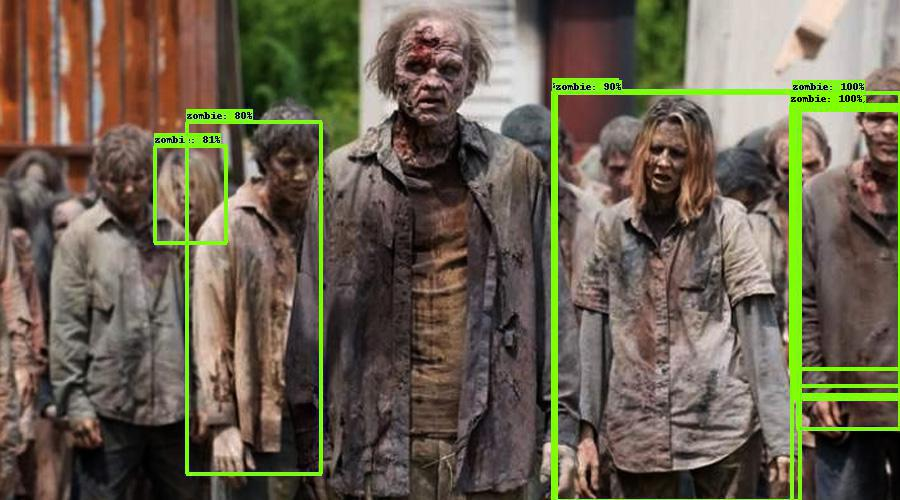

In [61]:
test_images_np_ = []

for i in range(0, 1):
    image_path = os.path.join('/content/test.jpg')
    print(image_path)
    test_images_np_.append(np.expand_dims(
      load_image_into_numpy_array(image_path), axis=0))
    
label_id_offset = 1
results = {'boxes': [], 'scores': []}

for i in range(1):
    input_tensor = tf.convert_to_tensor(test_images_np_[i], dtype=tf.float32)
    detections = detect(input_tensor)
    plot_detections(
      test_images_np_[i][0],
      detections['detection_boxes'][0].numpy(),
      detections['detection_classes'][0].numpy().astype(np.uint32)
      + label_id_offset,
      detections['detection_scores'][0].numpy(),
      category_index, figsize=(15, 20), image_name="./test.jpg")
    results['boxes'].append(detections['detection_boxes'][0][0].numpy())
    results['scores'].append(detections['detection_scores'][0][0].numpy())

print('Test')
display(IPyImage('./test.jpg'))